# CmdStanPy Tutorial: do inference over a model conditioned on data


## Overview

The CmdStanPy interface manages the pieces of the puzzle that comprise a Bayesian data analysis:

 + The model, written as a Stan program
 + The data, i.e., the definitions for all data variables in the Stan program
 + The inference engine configuration, i.e., all arguments to the CmdStan command-line interface
 + The inference engine outputs:  output and diagnostic files, console message, error messages, and process return codes.

The CmdStan interface is entirely file-based, therefore CmdStanPy manages the process of converting in-memory data structures to their file-based representation and vice versa.

### The Stan program

When working in CmdStanPy, all models must be supplied either as a Stan program file or as a compiled model executable file; or both, in which case, the base filenames must match.   While writing a program as a file requires a text editor, as opposed to the convenience of a Python notebook, in the long run, this is a more efficient way to develop complex models. 

### The data

Definitions of all data variables in the model are supplied either as a Python dictionary or as an on-disk data file which can be in either JSON or Rdump format.


### Inference Methods

For each of the inference methods on the `CmdStanModel` class, listed above, there is a result class defined which encapsulates the appropriate information and operations:

 + `sample` - returns a `CmdStanMCMC` object which contains all draws from all sampler chains.
 + `optimize` - returns a `CmdStanMLE` object which contains point estimates for all model variables.
 + `variational` - returns a `CmdStanVB` object which contains the approximate estimates.
 + `generate_quantities` - returns a `CmdStanGQ` object which contains the draws for the generated quantities variables.


### Output files and logs

Each run of an inference algorithm produces one or more output files in [Stan CSV format](https://mc-stan.org/docs/cmdstan-guide/stan-csv.html), as well as the messages written to stdout and stderr.  CmdStanPy uses per-run directories to keep all files together; the location of the directory can be specified when setting up the run, or it can be specified and/or changed afterwards via the `save_csvfiles` method, common to all inference method classes.

### Installation

* From the shell command line, install Python package from PyPI or directly from GitHub using the Python `pip` installer for Python3:

  + `pip3 install --upgrade cmdstanpy`
  + `pip3 install -e git+https://github.com/stan-dev/cmdstanpy`


* CmdStanPy uses CmdStan directly to compile and run Stan programs, therefore CmdStan must be installed locally.

  + if you have a working installation of CmdStan, set environment variable `CMDSTAN` to the full path to the top-level CmdStan directory.
  
  + if you don't already have CmdStan installed, run Python script `install_cmdstan` which downloads and compiles the latest release from https://github.com/stan-dev/cmdstan/releases.  By default this installs the latest version of CmdStan in the location `~/.cmdstan`.  Flags -d and -v are used to specify the directory and version, respectively.


## Hello World:  Compile and run CmdStan example model `bernoulli.stan`

Every CmdStan release has an `examples/bernoulli` directory which contains the Stan model and test data files.  In this example we compile the model and run the NUTS-HMC sampler to obtain the full posterior density.

  + The `CmdStanModel` class method `sample` invokes Stan's NUTS-HMC sampler which conditions the model on the input data and returns a `CmdStanMCMC` object. The `CmdStanMCMC` object contains the set of draws from the posterior plus metadata.
  + Runs any number of chains - default is 4 chains.
  + The output of each chain is stored on disk as a Stan csv file.


### Import CmdStanPy classes and methods

In [1]:
import os
from cmdstanpy import cmdstan_path, CmdStanModel

### Compile the model

The CmdStanPy directory `examples/bernoulli` contains the model and data files.

In [2]:
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
bernoulli_stan = os.path.join(bernoulli_dir, 'bernoulli.stan')
with open(bernoulli_stan, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}



The `CmdStanModel` object stores the filepaths of the Stan program and the compiled executable file.  By default, if no executable file is supplied, or if the timestamp on the model file is newer than the timestamp on the executable file, the model will be compiled on instantiation.

In [3]:
bernoulli_model = CmdStanModel(stan_file=bernoulli_stan)
print(bernoulli_model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/.cmdstan/cmdstan-2.26.0/examples/bernoulli/bernoulli


CmdStanModel: name=bernoulli
	 stan_file=/Users/mitzi/.cmdstan/cmdstan-2.26.0/examples/bernoulli/bernoulli.stan
	 exe_file=/Users/mitzi/.cmdstan/cmdstan-2.26.0/examples/bernoulli/bernoulli
	 compiler_options=stanc_options=None, cpp_options=None


### Assemble the data

Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.

If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [4]:
bern_data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

In the CmdStan `examples/bernoulli` directory, there are data files in both `JSON` and `rdump` formats.

In [5]:
bern_json = os.path.join(bernoulli_dir, 'bernoulli.data.json')
with open(bern_json, 'r') as f:
    print(f.read())

{
    "N" : 10,
    "y" : [0,1,0,0,0,0,0,0,0,1]
}



### Do Inference

The `CmdStanModel` class provides the following methods:

 + `sample` - run the HMC-NUTS sampler to produce a set of draws from the posterior distribution.
 + `optimize` - produce a penalized maximum likelihood estimate (point estimate) of the model parameters.
 + `variational` - run CmdStan’s variational inference algorithm to approximate the posterior distribution.
 + `generate_quantities` - run CmdStan’s generate_quantities method to produce additional quantities of interest based on each draw from an existing sample.
 

In this tutorial, we run the `sample` sample method.  By default, `sample` runs 4 sampler chains.

In [6]:
bern_fit = bernoulli_model.sample(data=bern_data)
print(bern_fit)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-1-wq_k_3js.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-2-o8490c4v.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-3-4yo3tqvx.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-4-offwotv2.csv
 output_files:
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-1-wq_k_3js-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-2-o8490c4v-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-3-4yo3tqvx-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-4-offwotv2-stdout.txt


### Access the sample: the `CmdStanMCMC` object attributes and methods

The CmdStanMCMC class has properties and methods to access the sampler outputs and all metadata.  Accessor properties include:

    + `draws`  - all draws from all chains, stored as a 3-D numpy.ndarray.
    + `num_draws` - total number of warmup and sampling draws
    + `chains` - number of chains run by sampler
    + `metric`, `stepsize` - per-chain HMC tuning parameters
    + `csv_files` - list of Stan csv output files which comprise the sample
    
The `draws` array is created only as needed; therefore the first time that this property is accessed, CmdStanPy parses the set of csv output files, at the same time it parses the contain stepsize and metric information.  Depending on the size of the sample and your computing environment, this may take a few seconds or more.

The numpy ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns)

In [7]:
bern_fit.draws().shape

(1000, 4, 8)

#### Viewing the sample as a set of variables:  sampler variables and program variables

The `CmdStanMCMC` property `draws` is a 3-D numpy ndarray which contains all draws across all chains.  
    
- `stan_variables` - dictionary mapping Stan program variables names to the draws for that variable.
- `sampler_variables` - dictionary mapping the sampler variables names, (e.g., `lp__`) to the draws for that variable.

theta (4000,)


<AxesSubplot:ylabel='Density'>

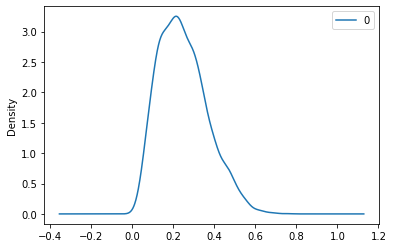

In [8]:
%matplotlib inline
import pandas as pd

vars = bern_fit.stan_variables()
for (k,v) in vars.items():
    print(k, v.shape)

thetas = bern_fit.stan_variable(name='theta')
pd.DataFrame(data=thetas).plot.density()

#### Get HMC sampler tuning parameters

##### stepsize

The `CmdStanMCMC` property `stepsize` property is a 1-D numpy ndarray which contains the stepsize used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the stepsize for the 4 chains in this example is:

In [9]:
bern_fit.stepsize

array([0.938294, 1.06715 , 1.11832 , 0.82201 ])

#### metric_type, metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `stepsize` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [10]:
bern_fit.metric_type,  bern_fit.metric

('diag_e',
 array([[0.616921],
        [0.419509],
        [0.406662],
        [0.554869]]))

#### Summarize the results

The `CmdStanMCMC` method `summary` returns output of CmdStan `bin/stansummary` as a pandas.DataFrame which contains
estimates of posterior means, standard deviations, Monte-Carlo standard error, effective sample size, and convergence diagnostic statistic for both the reported sampler parameters and all parameters, transformed parameters, and generated quantities variables:

In [11]:
bern_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.30,0.0170,0.70,-8.700,-7.00,-6.80,1700.0,33000.0,1.0
theta,0.25,0.0032,0.12,0.081,0.24,0.47,1300.0,26000.0,1.0


#### Run sampler diagnostics

The `CmdStanMCMC` method `diagnose` prints the output of CmdStan bin/stansummary to the console.  This is useful when the summary report shows `R_hat` values outside of the range of .99 to 1.01, or the number of effective samples (`N_eff` value) is below 5% of the total draws in the sample. 


   + The `CmdStanMCMC` class method `diagnose` invokes CmdStan's `diagnose` utility which checks for the following problems:
    + transitions that hit the maximum treedepth
    + divergent transitions
    + low E-BFMI values (sampler transitions HMC potential energy)
    + low effective sample sizes
    + high R-hat values
   + See the Stan reference manual section on [posterior analysis](https://mc-stan.org/docs/reference-manual/analysis-chapter.html) for further details.



In [12]:
bern_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-1-wq_k_3js.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-2-o8490c4v.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-3-4yo3tqvx.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-4-offwotv2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-1-wq_k_3js.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-2-o8490c4v.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-3-4yo3tqvx.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpig67uioy/bernoulli-202102041602-4-offwotv2.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'